In [2]:
%pylab
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation

from PIL import Image
from PIL import ImageDraw




Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [6]:
def plot_links(grid, value_name, autoscale=True, vmin=0., vmax=0., cmap_name='viridis', magnitude= False, lw=15, pixels_per_node=31, x_name='X', y_name='Y', var_name=''):#, logvalues=False ):
    pixel_xscaling_factor = pixels_per_node/grid.dx
    pixel_yscaling_factor = pixels_per_node/grid.dy
    im = Image.new('RGBA', (round(grid.grid_xdimension*pixel_xscaling_factor), round(grid.grid_ydimension*pixel_yscaling_factor)), (255,255,255,255))
    draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    for i, value in enumerate(values):
        draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        #xs = [link_head_x[i],link_tail_x[i]]
        #ys = [link_head_y[i],link_tail_y[i]]
        #img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))
    
    imshow(np.asarray(im), origin='lower', extent=(0,grid.grid_xdimension,0,grid.grid_ydimension))
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


In [4]:
mg = RasterModelGrid((75,125),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
thickness = 500.*np.ones(mg.number_of_nodes)
Z = mg.add_field('node', 'ice__thickness', thickness)
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')

#add input to node 
moulin_Q=1.
mg.at_node['input__discharge'][125*30+10]=moulin_Q
#set heads at edges
h[mg.nodes_at_left_edge] = 400.
h[mg.nodes_at_right_edge] = 300.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
#Set boundary types
mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
#Initialize flow in links (solver will update this, but it can't be zero)
Q[mg.active_links] = moulin_Q/mg.number_of_links
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

#Initialize random hydraulic diameters
d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.5*np.random.rand(mg.number_of_active_links)

#Create flow solver on grid
pfn = PresFlowNetwork(mg)
#Run flow solver
pfn.run_one_step()
#Create melt-creep solver for conduit size evolution
mc = MeltCreep(mg, dt=1000.)


Number of links =  18550
Number of nodes =  9375
Number of active links =  17835
Number of core nodes =  8979


/home/mcoving/anaconda3/lib/python3.7/site-packages/landlab/components/conduit_networks/pressurized_flow.py:145: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)


Number of iterations = 1 tolerance = 0.2939540653241156
Number of iterations = 2 tolerance = 0.15267268546658902
Number of iterations = 3 tolerance = 0.032048587129499366
Number of iterations = 4 tolerance = 0.015839693502071827
Number of iterations = 5 tolerance = 0.007461431056471646
Number of iterations = 6 tolerance = 0.0032224257330475143
Number of iterations = 7 tolerance = 0.001304463124874919
Number of iterations = 8 tolerance = 0.0013220204359215048
Number of iterations = 9 tolerance = 0.0008704710350917154
Number of iterations = 10 tolerance = 0.0003287590714311688
Number of iterations = 11 tolerance = 7.313252287580855e-05
Number of iterations = 12 tolerance = 1.306633772555931e-05
Number of iterations = 13 tolerance = 9.99635927922237e-07


In [ ]:
nsteps = 50000
step_start = 5001
fig1, axs = subplots(2,2,figsize=(10,6))
every = 25
for step in arange(nsteps)+step_start:
    print("step =",step, " avg d_h=",mg.at_link['hydraulic__diameter'].mean())
    pfn.run_one_step()    
    #mg.calc_grad_at_link(h, out=dhdx)
    #h = fsolve(network_residuals, h[mg.core_nodes])
    #Q = np.sign(dhdx)*np.sqrt(np.fabs(dhdx))
    mc.run_one_step()
    if (step % every)==0: #make an animation frame
        subplot(2,2,1)
        imshow_grid_at_node(mg, h, var_name='Head ($m$)', cmap='viridis')#,vmin=300,vmax=400)
        #plot(mg.at_node['hydraulic__head'][mg.core_nodes])
        #ylim([300,400])
        subplot(2,2,2)
        plot_links(mg, 'conduit__discharge', magnitude=True, var_name='Discharge ($m^3/s$)')#, vmin=0., vmax=1, autoscale=False)
        #plot(mg.at_link['conduit__discharge'][mg.active_links])
        #ylabel('')
        #ylim([0,1.5])
        subplot(2,2,3)
        plot_links(mg, 'hydraulic__diameter', var_name='Hydraulic diameter ($m$)')#, autoscale=False, vmin=0, vmax=1.25)
        subplot(2,2,4)#, position=[0.2,0.2,0.9,0.9])
        plot(mg.at_link['hydraulic__diameter'][mg.active_links])
        xlabel('Link number')
        ylabel('Hydraulic diameter ($m$)')
        ylim(0,1.25)
        #ylim([0.5,1.5])
        image_name = 'Big-example-grid/heads_and_discharge'+str(step).zfill(6)+'.png'
        #tight_layout()
        subplots_adjust(wspace=0.3)
        savefig(image_name,dpi=300)
        fig1.clf()


step = 5001  avg d_h= 0.16570461369966796
Number of iterations = 1 tolerance = 1.9140815321019855e-05
Number of iterations = 2 tolerance = 3.802709346562949e-09
max ddh =  0.0005018333186838854
step = 5002  avg d_h= 0.165664982562052
Number of iterations = 1 tolerance = 0.00019125802176154366
Number of iterations = 2 tolerance = 4.026975953002243e-07
max ddh =  0.000501870673893896
step = 5003  avg d_h= 0.16562538913015953
Number of iterations = 1 tolerance = 0.0001908329426737812
Number of iterations = 2 tolerance = 4.846817909793454e-07
max ddh =  0.0005018928863390871
step = 5004  avg d_h= 0.16558583321877215
Number of iterations = 1 tolerance = 0.0001904065179571049
Number of iterations = 2 tolerance = 5.448869287369429e-07
max ddh =  0.000501900383960708
step = 5005  avg d_h= 0.16554631464160238
Number of iterations = 1 tolerance = 0.00018999460961551667
Number of iterations = 2 tolerance = 6.188523596183652e-07
max ddh =  0.0005018935986975307
step = 5006  avg d_h= 0.165506833211

Number of iterations = 2 tolerance = 2.502160304632291e-06
max ddh =  0.0004944550545939252
step = 5044  avg d_h= 0.16403215954164188
Number of iterations = 1 tolerance = 0.00018339238560727278
Number of iterations = 2 tolerance = 1.8743241178266323e-06
max ddh =  0.0004939352080226365
step = 5045  avg d_h= 0.16399397766246834
Number of iterations = 1 tolerance = 0.0001834457270089955
Number of iterations = 2 tolerance = 2.219216172773333e-06
max ddh =  0.0004933880367131659
step = 5046  avg d_h= 0.16395582556758398
Number of iterations = 1 tolerance = 0.00018349847817056633
Number of iterations = 2 tolerance = 1.637932392521845e-06
max ddh =  0.000492814307034331
step = 5047  avg d_h= 0.16391770311340673
Number of iterations = 1 tolerance = 0.00018355588739380965
Number of iterations = 2 tolerance = 1.2668025178412816e-06
max ddh =  0.0004922148133879757
step = 5048  avg d_h= 0.16387961015639643
Number of iterations = 1 tolerance = 0.00018361633431729016
Number of iterations = 2 toler

Number of iterations = 1 tolerance = 0.00018577727939534522
Number of iterations = 2 tolerance = 8.433048481924339e-07
max ddh =  0.0004556807020308239
step = 5087  avg d_h= 0.16241595437288234
Number of iterations = 1 tolerance = 0.0001862069372779579
Number of iterations = 2 tolerance = 1.215774803333003e-06
max ddh =  0.0004545465326250898
step = 5088  avg d_h= 0.16237897119698258
Number of iterations = 1 tolerance = 0.00018687609903472735
Number of iterations = 2 tolerance = 1.9924685597655513e-06
max ddh =  0.0004534060832466839
step = 5089  avg d_h= 0.1623420149157811
Number of iterations = 1 tolerance = 0.00018782353459107642
Number of iterations = 2 tolerance = 1.4712909201172741e-06
max ddh =  0.00045226603470338583
step = 5090  avg d_h= 0.1623050855178812
Number of iterations = 1 tolerance = 0.00018670538691908933
Number of iterations = 2 tolerance = 8.598980457338867e-07
max ddh =  0.0004511226805905393
step = 5091  avg d_h= 0.16226818300983353
Number of iterations = 1 toler

Number of iterations = 2 tolerance = 4.194387423947545e-07
max ddh =  0.00045791049804172316
step = 5129  avg d_h= 0.16088587663409856
Number of iterations = 1 tolerance = 0.00017831062470131248
Number of iterations = 2 tolerance = 1.4395795923348442e-06
max ddh =  0.0004573738164479863
step = 5130  avg d_h= 0.16085002693769365
Number of iterations = 1 tolerance = 0.00017813220942731328
Number of iterations = 2 tolerance = 5.867125748637397e-07
max ddh =  0.00045679656210553056
step = 5131  avg d_h= 0.16081420414814449
Number of iterations = 1 tolerance = 0.00017795150348621364
Number of iterations = 2 tolerance = 7.012203544226706e-07
max ddh =  0.00045617988144943446
step = 5132  avg d_h= 0.1607784082486155
Number of iterations = 1 tolerance = 0.0001777781867445677
Number of iterations = 2 tolerance = 4.0810181041377513e-07
max ddh =  0.00045552448995072903
step = 5133  avg d_h= 0.16074263921239398
Number of iterations = 1 tolerance = 0.00017760644265975983
Number of iterations = 2 t

Number of iterations = 1 tolerance = 0.00017291706152626485
Number of iterations = 2 tolerance = 9.40620198806973e-07
max ddh =  0.00040977264070063185
step = 5172  avg d_h= 0.1593681663316474
Number of iterations = 1 tolerance = 0.00017283578923971837
Number of iterations = 2 tolerance = 9.340711475958052e-07
max ddh =  0.0004083866432941012
step = 5173  avg d_h= 0.15933343741614456
Number of iterations = 1 tolerance = 0.00017275267564093033
Number of iterations = 2 tolerance = 1.3982575797558128e-06
max ddh =  0.00040700996613897905
step = 5174  avg d_h= 0.1592987334474832
Number of iterations = 1 tolerance = 0.00017266899683953535
Number of iterations = 2 tolerance = 2.367812356923929e-06
max ddh =  0.00040564274613754536
step = 5175  avg d_h= 0.15926405435201071
Number of iterations = 1 tolerance = 0.00017260443237446937
Number of iterations = 2 tolerance = 1.0840195812440775e-06
max ddh =  0.0004042850699457082
step = 5176  avg d_h= 0.15922940008254682
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 7.810339180715148e-07
max ddh =  0.00042014370090808016
step = 5214  avg d_h= 0.1579302376010959
Number of iterations = 1 tolerance = 0.00017010960996593355
Number of iterations = 2 tolerance = 1.0296575947281635e-06
max ddh =  0.00042228831492502366
step = 5215  avg d_h= 0.1578964957711596
Number of iterations = 1 tolerance = 0.00016999142525993965
Number of iterations = 2 tolerance = 5.912870212829158e-07
max ddh =  0.0004244230554213069
step = 5216  avg d_h= 0.15786277598439685
Number of iterations = 1 tolerance = 0.00016984123002797974
Number of iterations = 2 tolerance = 4.457597375591006e-07
max ddh =  0.0004265472668084048
step = 5217  avg d_h= 0.1578290781849279
Number of iterations = 1 tolerance = 0.00016971395788538401
Number of iterations = 2 tolerance = 1.4334028159281222e-06
max ddh =  0.00042866063060067685
step = 5218  avg d_h= 0.15779540231471664
Number of iterations = 1 tolerance = 0.00016960794316151634
Number of iterations = 2 tol

Number of iterations = 1 tolerance = 0.0001659182544157256
Number of iterations = 2 tolerance = 1.3817760097442622e-06
max ddh =  0.0004972630571229408
step = 5257  avg d_h= 0.15649859363821764
Number of iterations = 1 tolerance = 0.0001659377860005265
Number of iterations = 2 tolerance = 2.241374961962416e-06
max ddh =  0.0004985187583611574
step = 5258  avg d_h= 0.1564657526524927
Number of iterations = 1 tolerance = 0.00016597152440835788
Number of iterations = 2 tolerance = 8.097558080829424e-07
max ddh =  0.0004997431052935063
step = 5259  avg d_h= 0.15643293169744632
Number of iterations = 1 tolerance = 0.00016599428026091434
Number of iterations = 2 tolerance = 1.0555974489442899e-06
max ddh =  0.0005009355148578484
step = 5260  avg d_h= 0.15640013076851128
Number of iterations = 1 tolerance = 0.00016602000580809295
Number of iterations = 2 tolerance = 4.490643855206961e-07
max ddh =  0.0005020957939328447
step = 5261  avg d_h= 0.15636734986017148
Number of iterations = 1 tolera

Number of iterations = 1 tolerance = 0.00016479356326468825
Number of iterations = 2 tolerance = 1.7765195089655683e-07
max ddh =  0.0005199529144404176
step = 5300  avg d_h= 0.1551044656704278
Number of iterations = 1 tolerance = 0.00016467449648176896
Number of iterations = 2 tolerance = 2.579412544901835e-07
max ddh =  0.0005197030111087713
step = 5301  avg d_h= 0.1550724798570331
Number of iterations = 1 tolerance = 0.00016455112376978498
Number of iterations = 2 tolerance = 2.0032539930353588e-07
max ddh =  0.0005194211555781607
step = 5302  avg d_h= 0.155040513529695
Number of iterations = 1 tolerance = 0.00016442067286191048
Number of iterations = 2 tolerance = 1.7165947189048958e-07
max ddh =  0.0005191080832366652
step = 5303  avg d_h= 0.1550085666567805
Number of iterations = 1 tolerance = 0.00016428950090793815
Number of iterations = 2 tolerance = 1.7036830074460452e-07
max ddh =  0.000518764499011483
step = 5304  avg d_h= 0.15497663920505667
Number of iterations = 1 toleran

Number of iterations = 1 tolerance = 0.000156621936590301
Number of iterations = 2 tolerance = 1.5958641095680105e-06
max ddh =  0.0004928954418558781
step = 5343  avg d_h= 0.15374619304941026
Number of iterations = 1 tolerance = 0.0001563704191749754
Number of iterations = 2 tolerance = 7.312716684585729e-07
max ddh =  0.0004919456420287631
step = 5344  avg d_h= 0.15371501009826413
Number of iterations = 1 tolerance = 0.00015612243766199158
Number of iterations = 2 tolerance = 1.3412835013906342e-06
max ddh =  0.000490995359628228
step = 5345  avg d_h= 0.15368384505531732
Number of iterations = 1 tolerance = 0.00015588065454268107
Number of iterations = 2 tolerance = 5.236624071437443e-07
max ddh =  0.0004900494478901765
step = 5346  avg d_h= 0.15365269789960168
Number of iterations = 1 tolerance = 0.00015563956134619777
Number of iterations = 2 tolerance = 4.3950086927533596e-07
max ddh =  0.0004891126817319346
step = 5347  avg d_h= 0.1536215686075863
Number of iterations = 1 toleran

Number of iterations = 2 tolerance = 7.116679906918504e-07
max ddh =  0.0004586181812426176
step = 5385  avg d_h= 0.15245167834632847
Number of iterations = 1 tolerance = 0.00014606749767964028
Number of iterations = 2 tolerance = 4.040184382950174e-07
max ddh =  0.0004555370603974368
step = 5386  avg d_h= 0.152421230842816
Number of iterations = 1 tolerance = 0.00014570763235621093
Number of iterations = 2 tolerance = 3.7643599004946737e-07
max ddh =  0.00045234840610198357
step = 5387  avg d_h= 0.15239080081800777
Number of iterations = 1 tolerance = 0.00014534703518519904
Number of iterations = 2 tolerance = 3.519208906545279e-07
max ddh =  0.00044906221756373793
step = 5388  avg d_h= 0.15236038831676812
Number of iterations = 1 tolerance = 0.0001449878214415945
Number of iterations = 2 tolerance = 3.289778644048613e-07
max ddh =  0.00044568798774271125
step = 5389  avg d_h= 0.15232999338189568
Number of iterations = 1 tolerance = 0.00014463038277195278
Number of iterations = 2 tole

Number of iterations = 2 tolerance = 4.113828641500109e-07
max ddh =  0.0003220364956118331
step = 5427  avg d_h= 0.15118826854587816
Number of iterations = 1 tolerance = 0.0001340654614649453
Number of iterations = 2 tolerance = 3.5808840109167583e-07
max ddh =  0.0003213468127461021
step = 5428  avg d_h= 0.15115857590357962
Number of iterations = 1 tolerance = 0.00013396069860594634
Number of iterations = 2 tolerance = 3.4555626870146853e-07
max ddh =  0.00032065592682971767
step = 5429  avg d_h= 0.1511289014239434
Number of iterations = 1 tolerance = 0.00013377481954890413
Number of iterations = 2 tolerance = 3.330884110221404e-07
max ddh =  0.0003199640633139506
step = 5430  avg d_h= 0.1510992451219002
Number of iterations = 1 tolerance = 0.00013343078366448435
Number of iterations = 2 tolerance = 6.058794196683118e-07
max ddh =  0.0003192714557175517
step = 5431  avg d_h= 0.15106960701609787
Number of iterations = 1 tolerance = 0.0001330817393215833
Number of iterations = 2 tolera

Number of iterations = 1 tolerance = 0.00012392844366217182
Number of iterations = 2 tolerance = 6.796071269059983e-07
max ddh =  0.00029372327599997127
step = 5470  avg d_h= 0.14992820308897245
Number of iterations = 1 tolerance = 0.00012377916319152027
Number of iterations = 2 tolerance = 5.241244363986958e-07
max ddh =  0.000293123605764827
step = 5471  avg d_h= 0.14989931526632655
Number of iterations = 1 tolerance = 0.00012362811335225182
Number of iterations = 2 tolerance = 4.1868260736502294e-07
max ddh =  0.0002925269208339615
step = 5472  avg d_h= 0.149870446674392
Number of iterations = 1 tolerance = 0.00012347544319354226
Number of iterations = 2 tolerance = 3.4305855142746644e-07
max ddh =  0.00029193317075978064
step = 5473  avg d_h= 0.14984159732693378
Number of iterations = 1 tolerance = 0.00012332254673377147
Number of iterations = 2 tolerance = 2.873557258097764e-07
max ddh =  0.0002913423688525348
step = 5474  avg d_h= 0.1498127672352399
Number of iterations = 1 toler

Number of iterations = 2 tolerance = 3.55278554975816e-07
max ddh =  0.00027032533262328316
step = 5512  avg d_h= 0.14873143770263353
Number of iterations = 1 tolerance = 0.00011991080656372638
Number of iterations = 2 tolerance = 9.38034692866363e-07
max ddh =  0.00026980132723912866
step = 5513  avg d_h= 0.14870335071322882
Number of iterations = 1 tolerance = 0.00011984921652138242
Number of iterations = 2 tolerance = 1.835119790126398e-07
max ddh =  0.00026927928062828844
step = 5514  avg d_h= 0.1486752822436354
Number of iterations = 1 tolerance = 0.0001197916498911801
Number of iterations = 2 tolerance = 6.620377360128178e-07
max ddh =  0.0002687595387903475
step = 5515  avg d_h= 0.14864723226266227
Number of iterations = 1 tolerance = 0.0001197348259844265
Number of iterations = 2 tolerance = 9.677984238538797e-07
max ddh =  0.00026824207903656887
step = 5516  avg d_h= 0.1486192007342799
Number of iterations = 1 tolerance = 0.00011968064286513314
Number of iterations = 2 toleran

Number of iterations = 1 tolerance = 0.0001171787096674072
Number of iterations = 2 tolerance = 4.854794017671374e-07
max ddh =  0.000258684784807399
step = 5555  avg d_h= 0.14753989952729032
Number of iterations = 1 tolerance = 0.00011715867933806412
Number of iterations = 2 tolerance = 8.075542699756411e-07
max ddh =  0.0002587133646229892
step = 5556  avg d_h= 0.14751256910088023
Number of iterations = 1 tolerance = 0.00011716565598285031
Number of iterations = 2 tolerance = 1.822039858447889e-06
max ddh =  0.00025873355849750045
step = 5557  avg d_h= 0.14748525517678523
Number of iterations = 1 tolerance = 0.00011707121917971935
Number of iterations = 2 tolerance = 1.0987531220780358e-06
max ddh =  0.0002587455733674936
step = 5558  avg d_h= 0.14745795770729933
Number of iterations = 1 tolerance = 0.0001169950828167135
Number of iterations = 2 tolerance = 7.570474538320081e-07
max ddh =  0.0002587493940305237
step = 5559  avg d_h= 0.14743067664366702
Number of iterations = 1 tolera

Number of iterations = 2 tolerance = 1.7964659570308402e-07
max ddh =  0.0002522308569457031
step = 5597  avg d_h= 0.14640567755575654
Number of iterations = 1 tolerance = 0.00011476730780165742
Number of iterations = 2 tolerance = 3.043779226985222e-07
max ddh =  0.00025188486611066617
step = 5598  avg d_h= 0.14637899976897936
Number of iterations = 1 tolerance = 0.00011472151352774976
Number of iterations = 2 tolerance = 2.6595425180157844e-07
max ddh =  0.0002515302766593954
step = 5599  avg d_h= 0.14635233659406222
Number of iterations = 1 tolerance = 0.000114681141393215
Number of iterations = 2 tolerance = 4.0091674573439526e-07
max ddh =  0.00025116715740692414
step = 5600  avg d_h= 0.1463256879882255
Number of iterations = 1 tolerance = 0.00011465034078084191
Number of iterations = 2 tolerance = 7.135031344683565e-07
max ddh =  0.00025079563122781833
step = 5601  avg d_h= 0.14629905390702855
Number of iterations = 1 tolerance = 0.00011464196247218394
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.00011270678828326913
Number of iterations = 2 tolerance = 6.751519536496976e-07
max ddh =  0.00023050551521818603
step = 5640  avg d_h= 0.14527124402697839
Number of iterations = 1 tolerance = 0.0001126977096497922
Number of iterations = 2 tolerance = 3.034545225898133e-07
max ddh =  0.00022986771385750295
step = 5641  avg d_h= 0.14524516038558366
Number of iterations = 1 tolerance = 0.00011267208196338863
Number of iterations = 2 tolerance = 8.711467430460141e-07
max ddh =  0.00022922530200395358
step = 5642  avg d_h= 0.14521908980171114
Number of iterations = 1 tolerance = 0.00011259603220514086
Number of iterations = 2 tolerance = 7.695735374486931e-07
max ddh =  0.0002285791198981782
step = 5643  avg d_h= 0.14519303224691316
Number of iterations = 1 tolerance = 0.00011252273940390994
Number of iterations = 2 tolerance = 9.054963482996144e-07
max ddh =  0.00022792953153374479
step = 5644  avg d_h= 0.14516698769318984
Number of iterations = 1 to

Number of iterations = 2 tolerance = 2.524292710291069e-07
max ddh =  0.00020387047284733237
step = 5682  avg d_h= 0.14418667196199422
Number of iterations = 1 tolerance = 0.00011021617388727589
Number of iterations = 2 tolerance = 2.644188429791624e-07
max ddh =  0.00020337846799770755
step = 5683  avg d_h= 0.1441611148196961
Number of iterations = 1 tolerance = 0.00011016428312547039
Number of iterations = 2 tolerance = 2.7576040822097515e-07
max ddh =  0.00020290700894377928
step = 5684  avg d_h= 0.14413556973879485
Number of iterations = 1 tolerance = 0.00011011073632702373
Number of iterations = 2 tolerance = 3.0452094493997953e-07
max ddh =  0.00020245824419490795
step = 5685  avg d_h= 0.14411003669910288
Number of iterations = 1 tolerance = 0.00011005132578760513
Number of iterations = 2 tolerance = 3.119783882032088e-07
max ddh =  0.00020203554266614722
step = 5686  avg d_h= 0.14408451568035704
Number of iterations = 1 tolerance = 0.0001099931614197483
Number of iterations = 2 

Number of iterations = 1 tolerance = 0.00010836534979979245
Number of iterations = 2 tolerance = 8.328063733824024e-07
max ddh =  0.00020723298421577825
step = 5725  avg d_h= 0.1430983604213526
Number of iterations = 1 tolerance = 0.00010835535107937833
Number of iterations = 2 tolerance = 4.398924897203795e-07
max ddh =  0.00020747718339005086
step = 5726  avg d_h= 0.1430733052022313
Number of iterations = 1 tolerance = 0.00010830693942195935
Number of iterations = 2 tolerance = 4.766638503093161e-07
max ddh =  0.00020772122738967966
step = 5727  avg d_h= 0.14304826135095355
Number of iterations = 1 tolerance = 0.00010826720311039179
Number of iterations = 2 tolerance = 2.8942214874218003e-06
max ddh =  0.0002079647156390494
step = 5728  avg d_h= 0.14302322887778968
Number of iterations = 1 tolerance = 0.00010823233659978948
Number of iterations = 2 tolerance = 8.777834013739758e-07
max ddh =  0.00020820746758583934
step = 5729  avg d_h= 0.1429982077907585
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 2.9230319975942094e-07
max ddh =  0.0002171587168006333
step = 5767  avg d_h= 0.14205577391069846
Number of iterations = 1 tolerance = 0.00010705611020011413
Number of iterations = 2 tolerance = 3.3055610578440605e-07
max ddh =  0.000217401361754435
step = 5768  avg d_h= 0.14203119052890184
Number of iterations = 1 tolerance = 0.0001070651852267332
Number of iterations = 2 tolerance = 8.523820479631632e-07
max ddh =  0.00021764641466966235
step = 5769  avg d_h= 0.14200661813196175
Number of iterations = 1 tolerance = 0.00010708092289794108
Number of iterations = 2 tolerance = 4.3837682873248627e-07
max ddh =  0.00021789441720549863
step = 5770  avg d_h= 0.1419820567053882
Number of iterations = 1 tolerance = 0.00010711003018783194
Number of iterations = 2 tolerance = 2.2974093053657052e-07
max ddh =  0.00021814080926740203
step = 5771  avg d_h= 0.1419575062293843
Number of iterations = 1 tolerance = 0.00010717334597923345
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.0001062170144446109
Number of iterations = 2 tolerance = 1.2309046748274353e-07
max ddh =  0.00022511982891755577
step = 5810  avg d_h= 0.14100843827361342
Number of iterations = 1 tolerance = 0.00010618853867033068
Number of iterations = 2 tolerance = 1.4860515446744318e-07
max ddh =  0.0002252619332074661
step = 5811  avg d_h= 0.14098431418371404
Number of iterations = 1 tolerance = 0.00010616136180919417
Number of iterations = 2 tolerance = 3.749513981369558e-07
max ddh =  0.00022540417191326478
step = 5812  avg d_h= 0.14096020041138274
Number of iterations = 1 tolerance = 0.0001061342974750315
Number of iterations = 2 tolerance = 2.4759235063944207e-07
max ddh =  0.00022554650728413326
step = 5813  avg d_h= 0.14093609694249082
Number of iterations = 1 tolerance = 0.00010610733305348174
Number of iterations = 2 tolerance = 3.50260170082838e-07
max ddh =  0.00022568894459774444
step = 5814  avg d_h= 0.14091200375867552
Number of iterations = 1 t

Number of iterations = 2 tolerance = 2.9304451616089106e-07
max ddh =  0.00023133349624315393
step = 5852  avg d_h= 0.14000392424619185
Number of iterations = 1 tolerance = 0.00010548419573090662
Number of iterations = 2 tolerance = 2.3516679100929472e-07
max ddh =  0.0002314894592627617
step = 5853  avg d_h= 0.13998021953046233
Number of iterations = 1 tolerance = 0.00010547702353427141
Number of iterations = 2 tolerance = 1.939716776635722e-07
max ddh =  0.00023164483622071554
step = 5854  avg d_h= 0.1399565244429768
Number of iterations = 1 tolerance = 0.00010547115149554809
Number of iterations = 2 tolerance = 4.643443775674676e-07
max ddh =  0.00023179967661594796
step = 5855  avg d_h= 0.13993283896642494
Number of iterations = 1 tolerance = 0.00010546697514823844
Number of iterations = 2 tolerance = 1.840940574241586e-06
max ddh =  0.00023195401594904743
step = 5856  avg d_h= 0.13990916308371285
Number of iterations = 1 tolerance = 0.00010546445294837281
Number of iterations = 2 

Number of iterations = 1 tolerance = 0.00010495129868270947
Number of iterations = 2 tolerance = 3.6847776972367963e-07
max ddh =  0.000237539454001343
step = 5895  avg d_h= 0.13899310570642714
Number of iterations = 1 tolerance = 0.00010492440012272591
Number of iterations = 2 tolerance = 2.148545437119509e-07
max ddh =  0.00023765471016042386
step = 5896  avg d_h= 0.13896980007837278
Number of iterations = 1 tolerance = 0.00010489887067849368
Number of iterations = 2 tolerance = 1.5942372049222035e-07
max ddh =  0.000237769692858577
step = 5897  avg d_h= 0.13894650342037196
Number of iterations = 1 tolerance = 0.00010487402536141915
Number of iterations = 2 tolerance = 2.0930237260891608e-07
max ddh =  0.0002378843502922406
step = 5898  avg d_h= 0.1389232157214681
Number of iterations = 1 tolerance = 0.00010484914233187259
Number of iterations = 2 tolerance = 1.2758019354445403e-07
max ddh =  0.00023799868273470455
step = 5899  avg d_h= 0.1388999369718143
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 9.096157257980125e-08
max ddh =  0.00024206551807511755
step = 5937  avg d_h= 0.13802187867693405
Number of iterations = 1 tolerance = 0.00010937378121846086
Number of iterations = 2 tolerance = 9.820214628796084e-08
max ddh =  0.00024216883998463406
step = 5938  avg d_h= 0.13799894147514324
Number of iterations = 1 tolerance = 0.00010950231558322365
Number of iterations = 2 tolerance = 1.0657317014683469e-07
max ddh =  0.00024227195324480567
step = 5939  avg d_h= 0.13797601285358757
Number of iterations = 1 tolerance = 0.00010963138211635137
Number of iterations = 2 tolerance = 1.1631957880409402e-07
max ddh =  0.000242374851240667
step = 5940  avg d_h= 0.13795309280636775
Number of iterations = 1 tolerance = 0.00010976100832469499
Number of iterations = 2 tolerance = 1.2774589134388202e-07
max ddh =  0.00024247753510189964
step = 5941  avg d_h= 0.1379301813183719
Number of iterations = 1 tolerance = 0.00010989183381561463
Number of iterations = 2 

Number of iterations = 1 tolerance = 0.0001141616647404517
Number of iterations = 2 tolerance = 3.3547094286389e-07
max ddh =  0.0002463052419934683
step = 5980  avg d_h= 0.1370432173771574
Number of iterations = 1 tolerance = 0.00011426730513404426
Number of iterations = 2 tolerance = 2.7216456233678676e-07
max ddh =  0.0002463991875447483
step = 5981  avg d_h= 0.1370206416659769
Number of iterations = 1 tolerance = 0.0001143727715115575
Number of iterations = 2 tolerance = 2.2642044342666384e-07
max ddh =  0.00024649254821776547
step = 5982  avg d_h= 0.13699807422587565
Number of iterations = 1 tolerance = 0.0001144784073238217
Number of iterations = 2 tolerance = 2.3593834264739925e-07
max ddh =  0.0002465853704767288
step = 5983  avg d_h= 0.13697551505122488
Number of iterations = 1 tolerance = 0.00011458231053625839
Number of iterations = 2 tolerance = 9.991823941567688e-07
max ddh =  0.0002466776452850526
step = 5984  avg d_h= 0.13695296413736757
Number of iterations = 1 toleranc

Number of iterations = 2 tolerance = 4.07426889641703e-07
max ddh =  0.00024997073946590894
step = 6022  avg d_h= 0.13610209901066134
Number of iterations = 1 tolerance = 0.00011835706778681038
Number of iterations = 2 tolerance = 3.570442395452853e-07
max ddh =  0.0002500348427113185
step = 6023  avg d_h= 0.13607986588895987
Number of iterations = 1 tolerance = 0.00011844070275830731
Number of iterations = 2 tolerance = 3.159655117607719e-07
max ddh =  0.00025009735931842155
step = 6024  avg d_h= 0.1360576407857952
Number of iterations = 1 tolerance = 0.00011852378638324557
Number of iterations = 2 tolerance = 2.821249437570092e-07
max ddh =  0.00025015838499932295
step = 6025  avg d_h= 0.13603542369868185
Number of iterations = 1 tolerance = 0.00011860706756226108
Number of iterations = 2 tolerance = 2.5367589607521866e-07
max ddh =  0.00025021800024138896
step = 6026  avg d_h= 0.13601321462293925
Number of iterations = 1 tolerance = 0.00011869042812255592
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.00012149573195835428
Number of iterations = 2 tolerance = 1.3655411341280996e-07
max ddh =  0.0002517407207854547
step = 6065  avg d_h= 0.13515325599600844
Number of iterations = 1 tolerance = 0.00012156002912080965
Number of iterations = 2 tolerance = 5.399411231952699e-07
max ddh =  0.0002517646848489143
step = 6066  avg d_h= 0.135131363559109
Number of iterations = 1 tolerance = 0.0001216243492385416
Number of iterations = 2 tolerance = 1.7086961845690803e-06
max ddh =  0.0002517879455845097
step = 6067  avg d_h= 0.13510947897216857
Number of iterations = 1 tolerance = 0.00012169202760164283
Number of iterations = 2 tolerance = 9.292446720987613e-07
max ddh =  0.0002518105376988634
step = 6068  avg d_h= 0.13508760223320151
Number of iterations = 1 tolerance = 0.00012174622214689707
Number of iterations = 2 tolerance = 1.4031028821963332e-07
max ddh =  0.0002518324714963322
step = 6069  avg d_h= 0.13506573334022925
Number of iterations = 1 toler

Number of iterations = 2 tolerance = 3.233224083189472e-07
max ddh =  0.0002521482015954294
step = 6107  avg d_h= 0.13424049446134131
Number of iterations = 1 tolerance = 0.00012324109978563424
Number of iterations = 2 tolerance = 3.9900628295423114e-07
max ddh =  0.00025214527845634355
step = 6108  avg d_h= 0.1342189287966157
Number of iterations = 1 tolerance = 0.00012325336447640417
Number of iterations = 2 tolerance = 2.0807030050711017e-07
max ddh =  0.0002521417948805568
step = 6109  avg d_h= 0.1341973708323385
Number of iterations = 1 tolerance = 0.00012326229666648203
Number of iterations = 2 tolerance = 2.0299792616610898e-07
max ddh =  0.00025213776305231636
step = 6110  avg d_h= 0.13417582056535785
Number of iterations = 1 tolerance = 0.00012327059214655572
Number of iterations = 2 tolerance = 1.943084950006954e-07
max ddh =  0.0002521331429979828
step = 6111  avg d_h= 0.13415427799562427
Number of iterations = 1 tolerance = 0.00012327712323443457
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.00012272791494535862
Number of iterations = 2 tolerance = 2.8378647177530227e-07
max ddh =  0.00025146471425871946
step = 6150  avg d_h= 0.1333201009082715
Number of iterations = 1 tolerance = 0.0001226970247953027
Number of iterations = 2 tolerance = 3.08626911913056e-07
max ddh =  0.0002514424120118568
step = 6151  avg d_h= 0.1332988646382495
Number of iterations = 1 tolerance = 0.00012266394695747973
Number of iterations = 2 tolerance = 1.5130097781324415e-07
max ddh =  0.0002514209947009192
step = 6152  avg d_h= 0.13327763599934972
Number of iterations = 1 tolerance = 0.00012262971428567138
Number of iterations = 2 tolerance = 3.3965334220263405e-07
max ddh =  0.0002514016850503192
step = 6153  avg d_h= 0.13325641498992544
Number of iterations = 1 tolerance = 0.00012259974303457932
Number of iterations = 2 tolerance = 2.165119257549585e-06
max ddh =  0.00025139423869028233
step = 6154  avg d_h= 0.13323520160506325
Number of iterations = 1 tole

Number of iterations = 2 tolerance = 1.0872009548364148e-07
max ddh =  0.00025015070554812674
step = 6192  avg d_h= 0.1324347332500011
Number of iterations = 1 tolerance = 0.00012049449467956691
Number of iterations = 2 tolerance = 1.0901696224051294e-07
max ddh =  0.00025010563555558936
step = 6193  avg d_h= 0.13241381660405063
Number of iterations = 1 tolerance = 0.00012042126724145369
Number of iterations = 2 tolerance = 1.0946823166164965e-07
max ddh =  0.0002500599269609812
step = 6194  avg d_h= 0.13239290756718852
Number of iterations = 1 tolerance = 0.00012034556872921737
Number of iterations = 2 tolerance = 1.0973582146266148e-07
max ddh =  0.0002500135837278842
step = 6195  avg d_h= 0.13237200613894576
Number of iterations = 1 tolerance = 0.00012026914971127733
Number of iterations = 2 tolerance = 1.1000396875869567e-07
max ddh =  0.0002499666111111288
step = 6196  avg d_h= 0.1323511123212275
Number of iterations = 1 tolerance = 0.0001201920265791745
Number of iterations = 2 t

Number of iterations = 1 tolerance = 0.00011674306965971104
Number of iterations = 2 tolerance = 1.1979740116574433e-07
max ddh =  0.00024772234551157825
step = 6235  avg d_h= 0.1315421626961122
Number of iterations = 1 tolerance = 0.00011663576045801982
Number of iterations = 2 tolerance = 1.199655469165395e-07
max ddh =  0.0002476566626290847
step = 6236  avg d_h= 0.1315215709760987
Number of iterations = 1 tolerance = 0.00011652830736458286
Number of iterations = 2 tolerance = 1.2223609608535968e-07
max ddh =  0.0002475908891268712
step = 6237  avg d_h= 0.13150098672134644
Number of iterations = 1 tolerance = 0.00011642085266569402
Number of iterations = 2 tolerance = 3.271257236204739e-07
max ddh =  0.0002475250721789319
step = 6238  avg d_h= 0.1314804099246904
Number of iterations = 1 tolerance = 0.00011631451212185118
Number of iterations = 2 tolerance = 1.4386399659060967e-07
max ddh =  0.00024745930318963594
step = 6239  avg d_h= 0.13145984057869736
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 1.6700239361712443e-07
max ddh =  0.0002442958015932513
step = 6277  avg d_h= 0.13068365410087593
Number of iterations = 1 tolerance = 0.00011163595828396489
Number of iterations = 2 tolerance = 2.7670488741803837e-07
max ddh =  0.00024418865087325774
step = 6278  avg d_h= 0.13066336943751997
Number of iterations = 1 tolerance = 0.00011150544579623112
Number of iterations = 2 tolerance = 5.25806594933228e-07
max ddh =  0.00024408047665465453
step = 6279  avg d_h= 0.130643091904002
Number of iterations = 1 tolerance = 0.00011137215185269556
Number of iterations = 2 tolerance = 1.2693151659956547e-07
max ddh =  0.0002439711290215881
step = 6280  avg d_h= 0.13062282149762833
Number of iterations = 1 tolerance = 0.00011124240028621835
Number of iterations = 2 tolerance = 1.2690030752084136e-07
max ddh =  0.00024386078584348166
step = 6281  avg d_h= 0.1306025582082394
Number of iterations = 1 tolerance = 0.00011111123142334978
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.00010685812817248785
Number of iterations = 2 tolerance = 1.6697377095433993e-07
max ddh =  0.00023882227137009054
step = 6320  avg d_h= 0.12981775137528945
Number of iterations = 1 tolerance = 0.00010684214997315478
Number of iterations = 2 tolerance = 1.9655629891551442e-07
max ddh =  0.00023867408043701555
step = 6321  avg d_h= 0.12979776631061743
Number of iterations = 1 tolerance = 0.00010682627789704302
Number of iterations = 2 tolerance = 4.009871747266878e-07
max ddh =  0.00023852499894921138
step = 6322  avg d_h= 0.12977778806624957
Number of iterations = 1 tolerance = 0.00010681324490049993
Number of iterations = 2 tolerance = 1.2992284443343743e-07
max ddh =  0.00023837506363533234
step = 6323  avg d_h= 0.12975781663827016
Number of iterations = 1 tolerance = 0.00010680114391944939
Number of iterations = 2 tolerance = 1.2995891030161133e-07
max ddh =  0.00023822428832455592
step = 6324  avg d_h= 0.12973785202140636
Number of iterations 

Number of iterations = 2 tolerance = 2.8449916469998413e-07
max ddh =  0.00023194046772141466
step = 6362  avg d_h= 0.1289842036404783
Number of iterations = 1 tolerance = 0.00010663856419967921
Number of iterations = 2 tolerance = 2.353145058205637e-07
max ddh =  0.00023176378764566525
step = 6363  avg d_h= 0.1289645011541808
Number of iterations = 1 tolerance = 0.00010666065768981381
Number of iterations = 2 tolerance = 1.9808511068790705e-07
max ddh =  0.0002315866836879905
step = 6364  avg d_h= 0.1289448052655339
Number of iterations = 1 tolerance = 0.00010668474678580259
Number of iterations = 2 tolerance = 1.6916430621008102e-07
max ddh =  0.00023140918713980319
step = 6365  avg d_h= 0.12892511596629747
Number of iterations = 1 tolerance = 0.0001067027579704713
Number of iterations = 2 tolerance = 1.460989516772709e-07
max ddh =  0.00023123118945078366
step = 6366  avg d_h= 0.1289054332495178
Number of iterations = 1 tolerance = 0.00010672388003038491
Number of iterations = 2 tol

Number of iterations = 1 tolerance = 0.00010746267416578831
Number of iterations = 2 tolerance = 1.2223350579800007e-07
max ddh =  0.00022414149005745923
step = 6405  avg d_h= 0.12814286992693075
Number of iterations = 1 tolerance = 0.00010748315121048707
Number of iterations = 2 tolerance = 1.2207051499919103e-07
max ddh =  0.00022396127251282893
step = 6406  avg d_h= 0.1281234448544674
Number of iterations = 1 tolerance = 0.00010750384796014145
Number of iterations = 2 tolerance = 1.2190882415271526e-07
max ddh =  0.00022378153592619092
step = 6407  avg d_h= 0.12810402607183544
Number of iterations = 1 tolerance = 0.00010752473240529387
Number of iterations = 2 tolerance = 1.2174755538961468e-07
max ddh =  0.00022360232383252337
step = 6408  avg d_h= 0.12808461357158737
Number of iterations = 1 tolerance = 0.00010754592615486863
Number of iterations = 2 tolerance = 1.215886712702119e-07
max ddh =  0.00022342367939600928
step = 6409  avg d_h= 0.12806520734677468
Number of iterations =

Number of iterations = 1 tolerance = 0.00010914386350607125
Number of iterations = 2 tolerance = 6.624933156420404e-07
max ddh =  0.0002171310025904873
step = 6447  avg d_h= 0.1273323649030294
Number of iterations = 1 tolerance = 0.00010934088852221358
Number of iterations = 2 tolerance = 2.2259243116589772e-07
max ddh =  0.00021700545470328665
step = 6448  avg d_h= 0.12731319917641645
Number of iterations = 1 tolerance = 0.0001095596484200767
Number of iterations = 2 tolerance = 2.471063859025351e-07
max ddh =  0.00021688569889770915
step = 6449  avg d_h= 0.12729403951941518
Number of iterations = 1 tolerance = 0.0001098075523241343
Number of iterations = 2 tolerance = 2.76590648904632e-07
max ddh =  0.00021677256425211788
step = 6450  avg d_h= 0.12727488592928712
Number of iterations = 1 tolerance = 0.00011009016315777914
Number of iterations = 2 tolerance = 3.1254971920085736e-07
max ddh =  0.00021666704636527176
step = 6451  avg d_h= 0.12725573839807797
Number of iterations = 1 tol

Number of iterations = 1 tolerance = 0.00010837889162323977
Number of iterations = 2 tolerance = 1.0285095096949914e-07
max ddh =  0.00020937653207292649
step = 6489  avg d_h= 0.12653259509881254
Number of iterations = 1 tolerance = 0.00010838065813711939
Number of iterations = 2 tolerance = 1.0245982172895837e-07
max ddh =  0.00020913247050804645
step = 6490  avg d_h= 0.12651368206602528
Number of iterations = 1 tolerance = 0.00010838285367884004
Number of iterations = 2 tolerance = 1.0219979191660594e-07
max ddh =  0.0002088875664830375
step = 6491  avg d_h= 0.12649477502390583
Number of iterations = 1 tolerance = 0.00010838542563439135
Number of iterations = 2 tolerance = 1.0193594428276054e-07
max ddh =  0.00020864190850575565
step = 6492  avg d_h= 0.12647587397014248
Number of iterations = 1 tolerance = 0.00010838845525133756
Number of iterations = 2 tolerance = 1.3392681946002157e-07
max ddh =  0.0002083955840239904
step = 6493  avg d_h= 0.12645697890226648
Number of iterations =

Number of iterations = 2 tolerance = 3.1800040081974254e-07
max ddh =  0.00019901605451317131
step = 6531  avg d_h= 0.12574338636848256
Number of iterations = 1 tolerance = 0.00010846596361362149
Number of iterations = 2 tolerance = 1.705748990700473e-07
max ddh =  0.00019877933838827002
step = 6532  avg d_h= 0.1257247232482998
Number of iterations = 1 tolerance = 0.00010846526729656192
Number of iterations = 2 tolerance = 1.319364492797207e-07
max ddh =  0.00019854346723285242
step = 6533  avg d_h= 0.12570606601219386
Number of iterations = 1 tolerance = 0.00010846602555499019
Number of iterations = 2 tolerance = 1.0669645950607777e-07
max ddh =  0.00019830852401418907
step = 6534  avg d_h= 0.12568741465745273
Number of iterations = 1 tolerance = 0.00010846842163879378
Number of iterations = 2 tolerance = 8.952793836792747e-08
max ddh =  0.00019807457793627822
step = 6535  avg d_h= 0.12566876918110892
Number of iterations = 1 tolerance = 0.00010847226618951322
Number of iterations = 2

Number of iterations = 1 tolerance = 0.00010865528839214267
Number of iterations = 2 tolerance = 9.210211655841238e-08
max ddh =  0.00019050151136051883
step = 6574  avg d_h= 0.12494613735602093
Number of iterations = 1 tolerance = 0.00010865919638651522
Number of iterations = 2 tolerance = 8.859336172603709e-08
max ddh =  0.0001903042169909109
step = 6575  avg d_h= 0.12492772385294039
Number of iterations = 1 tolerance = 0.00010866399450516762
Number of iterations = 2 tolerance = 1.0871071185790028e-07
max ddh =  0.00019010440851392822
step = 6576  avg d_h= 0.12490931610324964
Number of iterations = 1 tolerance = 0.0001086701366555115
Number of iterations = 2 tolerance = 1.378993745090046e-07
max ddh =  0.00018990243587562955
step = 6577  avg d_h= 0.12489091410713248
Number of iterations = 1 tolerance = 0.00010867783530459085
Number of iterations = 2 tolerance = 1.8313012772051726e-07
max ddh =  0.00018969861159399466
step = 6578  avg d_h= 0.12487251786202933
Number of iterations = 1 

Number of iterations = 2 tolerance = 2.991556828481629e-07
max ddh =  0.0001819281443183285
step = 6616  avg d_h= 0.12417769639873408
Number of iterations = 1 tolerance = 0.00010896616749046795
Number of iterations = 2 tolerance = 3.710410856875121e-07
max ddh =  0.0001817536597141669
step = 6617  avg d_h= 0.12415952211907995
Number of iterations = 1 tolerance = 0.00010899060479996336
Number of iterations = 2 tolerance = 5.524687987930908e-07
max ddh =  0.00018158411452820277
step = 6618  avg d_h= 0.12414135342503721
Number of iterations = 1 tolerance = 0.0001090176920416075
Number of iterations = 2 tolerance = 3.779284646187289e-07
max ddh =  0.00018142045605418528
step = 6619  avg d_h= 0.12412319030911144
Number of iterations = 1 tolerance = 0.00010903892230552936
Number of iterations = 2 tolerance = 4.5279870971232846e-07
max ddh =  0.00018126386635296067
step = 6620  avg d_h= 0.12410503276486347
Number of iterations = 1 tolerance = 0.00010905959876891802
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.00010892804728510064
Number of iterations = 2 tolerance = 2.976546658653762e-07
max ddh =  0.00017372258897488927
step = 6659  avg d_h= 0.12340122436777204
Number of iterations = 1 tolerance = 0.00010891874333347762
Number of iterations = 2 tolerance = 2.0875063294727768e-07
max ddh =  0.00017351340801989617
step = 6660  avg d_h= 0.12338328871446784
Number of iterations = 1 tolerance = 0.00010891104485043213
Number of iterations = 2 tolerance = 1.5678426060253858e-07
max ddh =  0.00017330388142387776
step = 6661  avg d_h= 0.12336535857331148
Number of iterations = 1 tolerance = 0.00010890465313760644
Number of iterations = 2 tolerance = 1.2845305292142861e-07
max ddh =  0.00017309410183802355
step = 6662  avg d_h= 0.12334743394260334
Number of iterations = 1 tolerance = 0.00010889921058247765
Number of iterations = 2 tolerance = 1.0039319916829224e-07
max ddh =  0.00017288414947312544
step = 6663  avg d_h= 0.12332951482443896
Number of iterations 

Number of iterations = 2 tolerance = 3.1171625729498893e-07
max ddh =  0.00016754894583066962
step = 6701  avg d_h= 0.12265264846951329
Number of iterations = 1 tolerance = 0.00010879944540927167
Number of iterations = 2 tolerance = 2.1722278824212043e-07
max ddh =  0.00016753228651899974
step = 6702  avg d_h= 0.12263494247352835
Number of iterations = 1 tolerance = 0.00010878925881949164
Number of iterations = 2 tolerance = 2.42503467620149e-07
max ddh =  0.0001675146780212131
step = 6703  avg d_h= 0.12261724189582371
Number of iterations = 1 tolerance = 0.00010878367151377633
Number of iterations = 2 tolerance = 6.238779487855495e-07
max ddh =  0.00016749605279180516
step = 6704  avg d_h= 0.12259954673469199
Number of iterations = 1 tolerance = 0.00010877767428825458
Number of iterations = 2 tolerance = 6.744456178958691e-08
max ddh =  0.000167477736362096
step = 6705  avg d_h= 0.1225818569916258
Number of iterations = 1 tolerance = 0.00010877311218862595
Number of iterations = 2 tol

Number of iterations = 1 tolerance = 0.00010858678440817116
Number of iterations = 2 tolerance = 7.021791406110173e-08
max ddh =  0.0001662235012351925
step = 6744  avg d_h= 0.12189616290810716
Number of iterations = 1 tolerance = 0.00010857675429358504
Number of iterations = 2 tolerance = 7.438272758365758e-08
max ddh =  0.00016617843877083938
step = 6745  avg d_h= 0.12187868835311877
Number of iterations = 1 tolerance = 0.00010856700304082145
Number of iterations = 2 tolerance = 7.907284475800044e-08
max ddh =  0.00016613279075048705
step = 6746  avg d_h= 0.12186121914060058
Number of iterations = 1 tolerance = 0.00010855718561918193
Number of iterations = 2 tolerance = 8.438657763463044e-08
max ddh =  0.00016608656119484946
step = 6747  avg d_h= 0.12184375526869405
Number of iterations = 1 tolerance = 0.00010854722358957791
Number of iterations = 2 tolerance = 9.046776042594424e-08
max ddh =  0.000166039755772822
step = 6748  avg d_h= 0.1218262967357938
Number of iterations = 1 tole

Number of iterations = 2 tolerance = 4.427620048375047e-08
max ddh =  0.00016396082433559064
step = 6786  avg d_h= 0.12116680552661263
Number of iterations = 1 tolerance = 0.00010823285009879668
Number of iterations = 2 tolerance = 4.436611534403001e-08
max ddh =  0.0001639018304351059
step = 6787  avg d_h= 0.12114955325062339
Number of iterations = 1 tolerance = 0.00010822625459039337
Number of iterations = 2 tolerance = 4.435918766337865e-08
max ddh =  0.00016384282749164737
step = 6788  avg d_h= 0.12113230620343922
Number of iterations = 1 tolerance = 0.00010821992694041993
Number of iterations = 2 tolerance = 4.418887320639664e-08
max ddh =  0.00016381943605748634
step = 6789  avg d_h= 0.121115064381677
Number of iterations = 1 tolerance = 0.00010821431736349196
Number of iterations = 2 tolerance = 1.033517401806702e-07
max ddh =  0.00016387926206384848
step = 6790  avg d_h= 0.12109782778188467
Number of iterations = 1 tolerance = 0.0001082109354453159
Number of iterations = 2 tole

Number of iterations = 1 tolerance = 0.00010792346497606742
Number of iterations = 2 tolerance = 5.215245147890957e-08
max ddh =  0.00016631909863361536
step = 6829  avg d_h= 0.12042963011002909
Number of iterations = 1 tolerance = 0.0001079147490079535
Number of iterations = 2 tolerance = 5.4098498129123707e-08
max ddh =  0.00016638802450812782
step = 6830  avg d_h= 0.12041259894839165
Number of iterations = 1 tolerance = 0.00010790618589559542
Number of iterations = 2 tolerance = 5.635569671688656e-08
max ddh =  0.00016645756777453383
step = 6831  avg d_h= 0.12039557282608176
Number of iterations = 1 tolerance = 0.00010789719130215036
Number of iterations = 2 tolerance = 9.189507408936795e-08
max ddh =  0.00016652768968835366
step = 6832  avg d_h= 0.12037855173704906
Number of iterations = 1 tolerance = 0.00010788825942081859
Number of iterations = 2 tolerance = 8.269420576207905e-08
max ddh =  0.00016659841253736886
step = 6833  avg d_h= 0.12036153567625713
Number of iterations = 1 

Number of iterations = 2 tolerance = 1.1181448585658691e-07
max ddh =  0.00017013926458408203
step = 6871  avg d_h= 0.11971859585818735
Number of iterations = 1 tolerance = 0.00010760346690805167
Number of iterations = 2 tolerance = 4.1247465572529646e-07
max ddh =  0.00017027260288205882
step = 6872  avg d_h= 0.11970177143727928
Number of iterations = 1 tolerance = 0.00010760157244886492
Number of iterations = 2 tolerance = 2.2249314789770988e-07
max ddh =  0.00017041087906327336
step = 6873  avg d_h= 0.11968495180217456
Number of iterations = 1 tolerance = 0.00010758832981115629
Number of iterations = 2 tolerance = 9.817338910683594e-08
max ddh =  0.00017055310688230088
step = 6874  avg d_h= 0.11966813694779802
Number of iterations = 1 tolerance = 0.00010757946630642057
Number of iterations = 2 tolerance = 8.856426051383204e-08
max ddh =  0.0001706919553060853
step = 6875  avg d_h= 0.11965132686653791
Number of iterations = 1 tolerance = 0.00010757089273417952
Number of iterations = 

Number of iterations = 1 tolerance = 0.00010712587345382274
Number of iterations = 2 tolerance = 2.180685583566544e-07
max ddh =  0.00017290119834880146
step = 6914  avg d_h= 0.1189993920751843
Number of iterations = 1 tolerance = 0.0001071101291177795
Number of iterations = 2 tolerance = 1.0528720370810846e-07
max ddh =  0.00017289845088985263
step = 6915  avg d_h= 0.1189827681831952
Number of iterations = 1 tolerance = 0.00010709446684153967
Number of iterations = 2 tolerance = 1.0765228101977806e-07
max ddh =  0.00017289361966614443
step = 6916  avg d_h= 0.11896614884583018
Number of iterations = 1 tolerance = 0.00010707885468608236
Number of iterations = 2 tolerance = 1.150998847118634e-07
max ddh =  0.0001728867611552491
step = 6917  avg d_h= 0.11894953405518459
Number of iterations = 1 tolerance = 0.00010706325221251922
Number of iterations = 2 tolerance = 1.2345094146590326e-07
max ddh =  0.0001728779303424151
step = 6918  avg d_h= 0.11893292380607931
Number of iterations = 1 to

Number of iterations = 2 tolerance = 4.3530943605392023e-07
max ddh =  0.00017160024403687537
step = 6956  avg d_h= 0.11830505421650969
Number of iterations = 1 tolerance = 0.00010687433690227677
Number of iterations = 2 tolerance = 3.431935439577905e-07
max ddh =  0.00017155336283573855
step = 6957  avg d_h= 0.11828861771047038
Number of iterations = 1 tolerance = 0.00010692955945312832
Number of iterations = 2 tolerance = 2.801625379006707e-07
max ddh =  0.00017150489043530462
step = 6958  avg d_h= 0.11827218558736645
Number of iterations = 1 tolerance = 0.00010698432039073225
Number of iterations = 2 tolerance = 2.347788619630207e-07
max ddh =  0.00017145503196250913
step = 6959  avg d_h= 0.11825575784620206
Number of iterations = 1 tolerance = 0.00010703882032321588
Number of iterations = 2 tolerance = 2.0077600762499824e-07
max ddh =  0.0001714039458757706
step = 6960  avg d_h= 0.11823933448451339
Number of iterations = 1 tolerance = 0.00010709301576705688
Number of iterations = 2

Number of iterations = 1 tolerance = 0.00010896983162315965
Number of iterations = 2 tolerance = 7.032933480734764e-08
max ddh =  0.00016903358788819659
step = 6999  avg d_h= 0.117602194093618
Number of iterations = 1 tolerance = 0.00010901060897101911
Number of iterations = 2 tolerance = 1.1207049417919285e-07
max ddh =  0.00016897298042547595
step = 7000  avg d_h= 0.11758594248155434
Number of iterations = 1 tolerance = 0.0001090517334537272
Number of iterations = 2 tolerance = 6.588961171996973e-08
max ddh =  0.00016891275370712884
step = 7001  avg d_h= 0.11756969507537725
Number of iterations = 1 tolerance = 0.00010908985466634435
Number of iterations = 2 tolerance = 6.700477973959023e-08
max ddh =  0.00016885295561125786
step = 7002  avg d_h= 0.11755345186965292
Number of iterations = 1 tolerance = 0.00010912879553939825
Number of iterations = 2 tolerance = 6.554541434913538e-08
max ddh =  0.0001687936266020782
step = 7003  avg d_h= 0.11753721285823984
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 3.783480028975617e-07
max ddh =  0.00016697467447289327
step = 7041  avg d_h= 0.11692319314593298
Number of iterations = 1 tolerance = 0.00011041445511388026
Number of iterations = 2 tolerance = 2.1585784797106822e-07
max ddh =  0.0001669233094294845
step = 7042  avg d_h= 0.11690711432568442
Number of iterations = 1 tolerance = 0.00011044113894535801
Number of iterations = 2 tolerance = 1.0112942943596415e-07
max ddh =  0.00016687101644783736
step = 7043  avg d_h= 0.11689103954610494
Number of iterations = 1 tolerance = 0.00011046996187044633
Number of iterations = 2 tolerance = 1.004536251530139e-07
max ddh =  0.00016681784233571261
step = 7044  avg d_h= 0.11687496880515459
Number of iterations = 1 tolerance = 0.00011049860532656719
Number of iterations = 2 tolerance = 9.931205571057705e-08
max ddh =  0.00016676382659139313
step = 7045  avg d_h= 0.11685890209907092
Number of iterations = 1 tolerance = 0.00011052738848781052
Number of iterations = 2

Number of iterations = 1 tolerance = 0.00011121325660411185
Number of iterations = 2 tolerance = 7.175618612225257e-08
max ddh =  0.00016426615597351694
step = 7084  avg d_h= 0.11623541589703953
Number of iterations = 1 tolerance = 0.00011122518760553479
Number of iterations = 2 tolerance = 6.198909423835511e-08
max ddh =  0.00016419850165744578
step = 7085  avg d_h= 0.11621950814225702
Number of iterations = 1 tolerance = 0.00011123677995963921
Number of iterations = 2 tolerance = 6.511825130527316e-08
max ddh =  0.0001641310955870789
step = 7086  avg d_h= 0.11620360429074862
Number of iterations = 1 tolerance = 0.00011124971042739129
Number of iterations = 2 tolerance = 6.077710650032042e-08
max ddh =  0.0001640639738169322
step = 7087  avg d_h= 0.1161877043374993
Number of iterations = 1 tolerance = 0.00011126355299018176
Number of iterations = 2 tolerance = 6.71226476520962e-08
max ddh =  0.00016399718427064167
step = 7088  avg d_h= 0.11617180827716349
Number of iterations = 1 tole

Number of iterations = 2 tolerance = 4.5400236951084963e-07
max ddh =  0.00016204115040536327
step = 7126  avg d_h= 0.115570620536353
Number of iterations = 1 tolerance = 0.00011121592805823921
Number of iterations = 2 tolerance = 3.2086254409788243e-07
max ddh =  0.00016203042128752756
step = 7127  avg d_h= 0.1155548745330409
Number of iterations = 1 tolerance = 0.00011120621017048082
Number of iterations = 2 tolerance = 1.884772209900798e-07
max ddh =  0.000162014242175492
step = 7128  avg d_h= 0.11553913232119133
Number of iterations = 1 tolerance = 0.00011119570198872553
Number of iterations = 2 tolerance = 1.656265056883613e-07
max ddh =  0.00016199288588382438
step = 7129  avg d_h= 0.11552339389759514
Number of iterations = 1 tolerance = 0.00011118485387723309
Number of iterations = 2 tolerance = 1.4696130027583992e-07
max ddh =  0.00016196692996922632
step = 7130  avg d_h= 0.11550765926039004
Number of iterations = 1 tolerance = 0.00011117367734626848
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.000110567364203909
Number of iterations = 2 tolerance = 2.6685057747354024e-07
max ddh =  0.00015951179035076128
step = 7169  avg d_h= 0.11489694396825442
Number of iterations = 1 tolerance = 0.00011054870689425345
Number of iterations = 2 tolerance = 1.951219825349596e-07
max ddh =  0.00015943644190505703
step = 7170  avg d_h= 0.11488135942638017
Number of iterations = 1 tolerance = 0.00011052826771303093
Number of iterations = 2 tolerance = 1.1095208402260266e-07
max ddh =  0.00015936130049216588
step = 7171  avg d_h= 0.11486577860036655
Number of iterations = 1 tolerance = 0.00011050777741195006
Number of iterations = 2 tolerance = 8.999868663659829e-08
max ddh =  0.0001592863918014304
step = 7172  avg d_h= 0.11485020148821222
Number of iterations = 1 tolerance = 0.00011048701755458912
Number of iterations = 2 tolerance = 7.63166200305518e-08
max ddh =  0.00015921174820213645
step = 7173  avg d_h= 0.11483462809193266
Number of iterations = 1 to

Number of iterations = 2 tolerance = 7.228172427264923e-08
max ddh =  0.00015626010673587749
step = 7211  avg d_h= 0.11424557493078145
Number of iterations = 1 tolerance = 0.0001094641708704186
Number of iterations = 2 tolerance = 7.245236036124147e-08
max ddh =  0.0001561808306085543
step = 7212  avg d_h= 0.11423014511439288
Number of iterations = 1 tolerance = 0.00010943232363981592
Number of iterations = 2 tolerance = 7.087912330672186e-08
max ddh =  0.00015610159986855832
step = 7213  avg d_h= 0.11421471894412834
Number of iterations = 1 tolerance = 0.00010939585657790407
Number of iterations = 2 tolerance = 6.990874060197605e-08
max ddh =  0.00015602242044358809
step = 7214  avg d_h= 0.11419929641827067
Number of iterations = 1 tolerance = 0.00010935786941856929
Number of iterations = 2 tolerance = 7.008008195974469e-08
max ddh =  0.00015594329984173772
step = 7215  avg d_h= 0.11418387753488836
Number of iterations = 1 tolerance = 0.00010931962511610827
Number of iterations = 2 to

Number of iterations = 1 tolerance = 0.00010755250629140845
Number of iterations = 2 tolerance = 1.0104716159922482e-07
max ddh =  0.00015295348524348637
step = 7254  avg d_h= 0.11358536372884837
Number of iterations = 1 tolerance = 0.00010749876622469234
Number of iterations = 2 tolerance = 7.294143071490122e-08
max ddh =  0.00015288066368600756
step = 7255  avg d_h= 0.11357008912242748
Number of iterations = 1 tolerance = 0.00010744466971376876
Number of iterations = 2 tolerance = 7.300205688565153e-08
max ddh =  0.000152808219990559
step = 7256  avg d_h= 0.11355481808710681
Number of iterations = 1 tolerance = 0.0001073902294083523
Number of iterations = 2 tolerance = 7.306530673545364e-08
max ddh =  0.00015273615556623204
step = 7257  avg d_h= 0.1135395506209165
Number of iterations = 1 tolerance = 0.00010733545293954705
Number of iterations = 2 tolerance = 7.310837003837722e-08
max ddh =  0.00015266447194188377
step = 7258  avg d_h= 0.11352428672185277
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 1.7618290058508538e-07
max ddh =  0.00015023518995004192
step = 7296  avg d_h= 0.11294688036805414
Number of iterations = 1 tolerance = 0.00010501622679073841
Number of iterations = 2 tolerance = 2.088440139833804e-07
max ddh =  0.00015017879656127996
step = 7297  avg d_h= 0.11293175383024337
Number of iterations = 1 tolerance = 0.00010495365996672501
Number of iterations = 2 tolerance = 1.1136755049580283e-07
max ddh =  0.00015012275364525767
step = 7298  avg d_h= 0.1129166307658463
Number of iterations = 1 tolerance = 0.00010488891270613032
Number of iterations = 2 tolerance = 1.2398777084260672e-07
max ddh =  0.00015006706682047527
step = 7299  avg d_h= 0.11290151117157429
Number of iterations = 1 tolerance = 0.00010482435573302973
Number of iterations = 2 tolerance = 8.275107872902015e-08
max ddh =  0.00015001173682411192
step = 7300  avg d_h= 0.1128863950456637
Number of iterations = 1 tolerance = 0.0001047586556476715
Number of iterations = 2 

Number of iterations = 1 tolerance = 0.0001023764510562214
Number of iterations = 2 tolerance = 9.726711323663086e-08
max ddh =  0.0001481698534673517
step = 7339  avg d_h= 0.11229954369366411
Number of iterations = 1 tolerance = 0.000102385602398114
Number of iterations = 2 tolerance = 9.549074129023706e-08
max ddh =  0.00014812739722772403
step = 7340  avg d_h= 0.11228456413791212
Number of iterations = 1 tolerance = 0.00010239480348403496
Number of iterations = 2 tolerance = 9.402137543748786e-08
max ddh =  0.00014808517936694223
step = 7341  avg d_h= 0.11226958794152443
Number of iterations = 1 tolerance = 0.00010240424334304055
Number of iterations = 2 tolerance = 9.491000130946719e-08
max ddh =  0.00014804320922814153
step = 7342  avg d_h= 0.11225461510262023
Number of iterations = 1 tolerance = 0.00010241389058107675
Number of iterations = 2 tolerance = 1.1565549704646218e-07
max ddh =  0.00014800149032769022
step = 7343  avg d_h= 0.11223964561727766
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 7.505533292095912e-08
max ddh =  0.00014661293807811783
step = 7381  avg d_h= 0.111673263072597
Number of iterations = 1 tolerance = 0.00010283661891019591
Number of iterations = 2 tolerance = 7.503184593082857e-08
max ddh =  0.00014658130186083593
step = 7382  avg d_h= 0.11165842216215098
Number of iterations = 1 tolerance = 0.00010284661839790599
Number of iterations = 2 tolerance = 7.501201290671666e-08
max ddh =  0.00014654987669343358
step = 7383  avg d_h= 0.1116435844784963
Number of iterations = 1 tolerance = 0.0001028567262707919
Number of iterations = 2 tolerance = 7.503283433463181e-08
max ddh =  0.00014651866380706395
step = 7384  avg d_h= 0.11162875001984388
Number of iterations = 1 tolerance = 0.00010286696464713307
Number of iterations = 2 tolerance = 7.50270112842566e-08
max ddh =  0.00014648766468154642
step = 7385  avg d_h= 0.11161391878615974
Number of iterations = 1 tolerance = 0.00010287732780658865
Number of iterations = 2 toler

Number of iterations = 1 tolerance = 0.00010334776591441885
Number of iterations = 2 tolerance = 7.401272471285747e-08
max ddh =  0.0001454541492476353
step = 7424  avg d_h= 0.11103798584289507
Number of iterations = 1 tolerance = 0.00010336268070511301
Number of iterations = 2 tolerance = 7.394538653615612e-08
max ddh =  0.0001454323996452381
step = 7425  avg d_h= 0.11102328110461014
Number of iterations = 1 tolerance = 0.00010337774685351131
Number of iterations = 2 tolerance = 7.389854835004872e-08
max ddh =  0.00014541090517970157
step = 7426  avg d_h= 0.11100857945671488
Number of iterations = 1 tolerance = 0.00010339294922280529
Number of iterations = 2 tolerance = 7.38108010406302e-08
max ddh =  0.00014538966652675664
step = 7427  avg d_h= 0.11099388089567497
Number of iterations = 1 tolerance = 0.00010340830014943236
Number of iterations = 2 tolerance = 7.372508693814783e-08
max ddh =  0.00014536868551826585
step = 7428  avg d_h= 0.11097918541807367
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 7.1152127814611e-08
max ddh =  0.00014473629392558425
step = 7466  avg d_h= 0.11042301046724312
Number of iterations = 1 tolerance = 0.00010399360025820092
Number of iterations = 2 tolerance = 7.113494245036822e-08
max ddh =  0.00014472359282212714
step = 7467  avg d_h= 0.11040843280676042
Number of iterations = 1 tolerance = 0.00010400940358840094
Number of iterations = 2 tolerance = 7.110383222486139e-08
max ddh =  0.00014471110226628607
step = 7468  avg d_h= 0.11039385810984172
Number of iterations = 1 tolerance = 0.00010402527477886003
Number of iterations = 2 tolerance = 7.1088259778751e-08
max ddh =  0.00014469882360416416
step = 7469  avg d_h= 0.110379286375043
Number of iterations = 1 tolerance = 0.00010404123054971737
Number of iterations = 2 tolerance = 7.104923528677975e-08
max ddh =  0.0001446867588611332
step = 7470  avg d_h= 0.110364717599529
Number of iterations = 1 tolerance = 0.00010405735872351385
Number of iterations = 2 tolerance

Number of iterations = 1 tolerance = 0.00010474738676827244
Number of iterations = 2 tolerance = 2.0799316983047986e-07
max ddh =  0.00014440395039842669
step = 7509  avg d_h= 0.10979881426370396
Number of iterations = 1 tolerance = 0.00010476627236134795
Number of iterations = 2 tolerance = 1.603814080976846e-07
max ddh =  0.00014440230245490996
step = 7510  avg d_h= 0.10978436166641611
Number of iterations = 1 tolerance = 0.00010478551372115896
Number of iterations = 2 tolerance = 1.28442811188009e-07
max ddh =  0.00014440096865600929
step = 7511  avg d_h= 0.10976991191980995
Number of iterations = 1 tolerance = 0.00010480500072559962
Number of iterations = 2 tolerance = 1.0579512444919216e-07
max ddh =  0.000144399957504008
step = 7512  avg d_h= 0.10975546502302626
Number of iterations = 1 tolerance = 0.00010482477264472934
Number of iterations = 2 tolerance = 8.978864904648451e-08
max ddh =  0.00014439927801974733
step = 7513  avg d_h= 0.10974102097574341
Number of iterations = 1 t

Number of iterations = 2 tolerance = 6.292416326880712e-08
max ddh =  0.00014468245937193124
step = 7551  avg d_h= 0.10919423246921275
Number of iterations = 1 tolerance = 0.00010557315725695515
Number of iterations = 2 tolerance = 6.267595320519348e-08
max ddh =  0.000144700157100002
step = 7552  avg d_h= 0.10917989756989645
Number of iterations = 1 tolerance = 0.00010558728748243096
Number of iterations = 2 tolerance = 6.253129671007773e-08
max ddh =  0.00014471694663935526
step = 7553  avg d_h= 0.10916556542256309
Number of iterations = 1 tolerance = 0.00010560393035578819
Number of iterations = 2 tolerance = 6.240821148750797e-08
max ddh =  0.0001447328539130387
step = 7554  avg d_h= 0.10915123602447659
Number of iterations = 1 tolerance = 0.0001056193266862765
Number of iterations = 2 tolerance = 6.226520823937598e-08
max ddh =  0.00014474789711551897
step = 7555  avg d_h= 0.10913690937557058
Number of iterations = 1 tolerance = 0.00010563494432858089
Number of iterations = 2 tole

Number of iterations = 1 tolerance = 0.00010623923436452187
Number of iterations = 2 tolerance = 5.971800156048224e-08
max ddh =  0.00014484497498697406
step = 7594  avg d_h= 0.10858028973361711
Number of iterations = 1 tolerance = 0.00010625057042562558
Number of iterations = 2 tolerance = 5.818514199618097e-08
max ddh =  0.00014483821292779863
step = 7595  avg d_h= 0.1085660711881754
Number of iterations = 1 tolerance = 0.00010626184435105768
Number of iterations = 2 tolerance = 1.0534655558940734e-07
max ddh =  0.00014483105207840539
step = 7596  avg d_h= 0.10855185530461484
Number of iterations = 1 tolerance = 0.00010627233374228828
Number of iterations = 2 tolerance = 5.800814395495735e-08
max ddh =  0.00014482348930365817
step = 7597  avg d_h= 0.10853764208171593
Number of iterations = 1 tolerance = 0.0001062822971255456
Number of iterations = 2 tolerance = 5.787458583206284e-08
max ddh =  0.00014481553432014674
step = 7598  avg d_h= 0.1085234315182474
Number of iterations = 1 to

Number of iterations = 2 tolerance = 7.196334597323051e-08
max ddh =  0.0001442914832365631
step = 7636  avg d_h= 0.10798538934388029
Number of iterations = 1 tolerance = 0.00010665349117967848
Number of iterations = 2 tolerance = 5.4406301755460795e-08
max ddh =  0.00014427339063711556
step = 7637  avg d_h= 0.10797128157961507
Number of iterations = 1 tolerance = 0.00010666251541713301
Number of iterations = 2 tolerance = 5.46118784916505e-08
max ddh =  0.00014425512903162602
step = 7638  avg d_h= 0.10795717642706991
Number of iterations = 1 tolerance = 0.00010667166778917381
Number of iterations = 2 tolerance = 7.079901780777811e-08
max ddh =  0.00014423670411418756
step = 7639  avg d_h= 0.10794307388322458
Number of iterations = 1 tolerance = 0.00010668097583141356
Number of iterations = 2 tolerance = 1.0903486914516657e-07
max ddh =  0.00014421812006276867
step = 7640  avg d_h= 0.1079289739476781
Number of iterations = 1 tolerance = 0.00010669010806063639
Number of iterations = 2 t

Number of iterations = 1 tolerance = 0.00010686826518153947
Number of iterations = 2 tolerance = 4.825812907616189e-08
max ddh =  0.00014344067766190917
step = 7679  avg d_h= 0.10738109729240103
Number of iterations = 1 tolerance = 0.00010687162283196106
Number of iterations = 2 tolerance = 4.8159268503655817e-08
max ddh =  0.00014342037940813496
step = 7680  avg d_h= 0.1073671005943544
Number of iterations = 1 tolerance = 0.00010687492389239994
Number of iterations = 2 tolerance = 4.805896169912671e-08
max ddh =  0.0001434001095151884
step = 7681  avg d_h= 0.10735310644581561
Number of iterations = 1 tolerance = 0.00010687817351610895
Number of iterations = 2 tolerance = 4.7956795756753934e-08
max ddh =  0.00014337987024812127
step = 7682  avg d_h= 0.10733911484498808
Number of iterations = 1 tolerance = 0.00010688137371980821
Number of iterations = 2 tolerance = 4.785241027038811e-08
max ddh =  0.00014335966387336863
step = 7683  avg d_h= 0.10732512579022517
Number of iterations = 1 

Number of iterations = 2 tolerance = 4.412495381578285e-08
max ddh =  0.0001426345109197538
step = 7721  avg d_h= 0.10679541106531562
Number of iterations = 1 tolerance = 0.0001069603282526227
Number of iterations = 2 tolerance = 4.403979567135785e-08
max ddh =  0.00014261697581057322
step = 7722  avg d_h= 0.10678151991079533
Number of iterations = 1 tolerance = 0.00010696025016800059
Number of iterations = 2 tolerance = 4.3937168722751885e-08
max ddh =  0.00014259955258804166
step = 7723  avg d_h= 0.10676763123435803
Number of iterations = 1 tolerance = 0.00010696021776267217
Number of iterations = 2 tolerance = 4.384751113584162e-08
max ddh =  0.00014258224443954254
step = 7724  avg d_h= 0.10675374503499396
Number of iterations = 1 tolerance = 0.00010696021032823022
Number of iterations = 2 tolerance = 4.3768984159253677e-08
max ddh =  0.00014256505501666458
step = 7725  avg d_h= 0.10673986131025812
Number of iterations = 1 tolerance = 0.00010696020659495264
Number of iterations = 2 

Number of iterations = 1 tolerance = 0.00010698187742344545
Number of iterations = 2 tolerance = 6.045864838126183e-08
max ddh =  0.00014306437792139826
step = 7764  avg d_h= 0.106200311922611
Number of iterations = 1 tolerance = 0.00010698296012366659
Number of iterations = 2 tolerance = 6.670451025818515e-08
max ddh =  0.00014309501804628312
step = 7765  avg d_h= 0.10618652602358604
Number of iterations = 1 tolerance = 0.00010698370202379126
Number of iterations = 2 tolerance = 7.19161121134373e-08
max ddh =  0.00014312565772415446
step = 7766  avg d_h= 0.10617274253374556
Number of iterations = 1 tolerance = 0.00010698477250992156
Number of iterations = 2 tolerance = 8.085864177835863e-08
max ddh =  0.00014315630077508897
step = 7767  avg d_h= 0.10615896145159276
Number of iterations = 1 tolerance = 0.00010698609826402528
Number of iterations = 2 tolerance = 2.2414482007265812e-07
max ddh =  0.0001431869611358971
step = 7768  avg d_h= 0.10614518277725611
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 2.639555845256962e-07
max ddh =  0.00014436484369064032
step = 7806  avg d_h= 0.10562335807069193
Number of iterations = 1 tolerance = 0.00010702363546184757
Number of iterations = 2 tolerance = 3.414058225015282e-08
max ddh =  0.00014439654052388298
step = 7807  avg d_h= 0.10560967176193055
Number of iterations = 1 tolerance = 0.00010702444610853623
Number of iterations = 2 tolerance = 3.401320398943586e-08
max ddh =  0.00014442830352687133
step = 7808  avg d_h= 0.1055959877794194
Number of iterations = 1 tolerance = 0.00010702532906246842
Number of iterations = 2 tolerance = 3.3879193409025454e-08
max ddh =  0.00014446013613857728
step = 7809  avg d_h= 0.10558230612379621
Number of iterations = 1 tolerance = 0.00010702630280617909
Number of iterations = 2 tolerance = 3.369576968836885e-08
max ddh =  0.00014449204201805014
step = 7810  avg d_h= 0.10556862679090175
Number of iterations = 1 tolerance = 0.00010702737358614378
Number of iterations = 2 

Number of iterations = 1 tolerance = 0.00010704225846397408
Number of iterations = 2 tolerance = 2.6668464556976816e-07
max ddh =  0.00014587944527639862
step = 7849  avg d_h= 0.10503692310680086
Number of iterations = 1 tolerance = 0.00010704580246781448
Number of iterations = 2 tolerance = 2.569891590509717e-07
max ddh =  0.00014592648358114344
step = 7850  avg d_h= 0.10502333497404062
Number of iterations = 1 tolerance = 0.0001070471288556335
Number of iterations = 2 tolerance = 1.944200770393617e-07
max ddh =  0.0001459723429276909
step = 7851  avg d_h= 0.10500974907248481
Number of iterations = 1 tolerance = 0.00010704296345813435
Number of iterations = 2 tolerance = 1.5518278666075414e-07
max ddh =  0.00014601645749122235
step = 7852  avg d_h= 0.104996165398204
Number of iterations = 1 tolerance = 0.0001070393885805182
Number of iterations = 2 tolerance = 2.148495531882267e-07
max ddh =  0.00014605916105171044
step = 7853  avg d_h= 0.10498258395001427
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 3.4936750737193933e-08
max ddh =  0.00014738894429258397
step = 7891  avg d_h= 0.10446811845030259
Number of iterations = 1 tolerance = 0.00010699132842981185
Number of iterations = 2 tolerance = 3.287787469184733e-08
max ddh =  0.00014742234755150103
step = 7892  avg d_h= 0.10445462216440887
Number of iterations = 1 tolerance = 0.00010699143834733138
Number of iterations = 2 tolerance = 3.1249346319389736e-08
max ddh =  0.0001474558012847086
step = 7893  avg d_h= 0.10444112801941947
Number of iterations = 1 tolerance = 0.00010699146624362776
Number of iterations = 2 tolerance = 3.164420286469092e-08
max ddh =  0.00014748931101555405
step = 7894  avg d_h= 0.10442763601320951
Number of iterations = 1 tolerance = 0.00010699153592583222
Number of iterations = 2 tolerance = 3.207378525873486e-08
max ddh =  0.00014752288283754659
step = 7895  avg d_h= 0.10441414614385452
Number of iterations = 1 tolerance = 0.00010699166103829427
Number of iterations = 2

Number of iterations = 1 tolerance = 0.00010697177198230878
Number of iterations = 2 tolerance = 6.442863049125334e-08
max ddh =  0.00014895605231107537
step = 7934  avg d_h= 0.10388968503349268
Number of iterations = 1 tolerance = 0.00010696682916368216
Number of iterations = 2 tolerance = 6.718266462570554e-08
max ddh =  0.00014899820216236718
step = 7935  avg d_h= 0.10387627887678376
Number of iterations = 1 tolerance = 0.00010696198256629486
Number of iterations = 2 tolerance = 7.014127109081789e-08
max ddh =  0.00014904065066972862
step = 7936  avg d_h= 0.1038628747694863
Number of iterations = 1 tolerance = 0.00010695722897399729
Number of iterations = 2 tolerance = 7.32918458934916e-08
max ddh =  0.00014908340196252993
step = 7937  avg d_h= 0.10384947271037173
Number of iterations = 1 tolerance = 0.00010695235371641076
Number of iterations = 2 tolerance = 8.845433611989077e-08
max ddh =  0.0001491264589017305
step = 7938  avg d_h= 0.10383607269715558
Number of iterations = 1 tol

Number of iterations = 2 tolerance = 5.812429769123939e-07
max ddh =  0.00015109634404841314
step = 7976  avg d_h= 0.10332836962179731
Number of iterations = 1 tolerance = 0.00010683543603594303
Number of iterations = 2 tolerance = 8.867442369503932e-07
max ddh =  0.000151160205738384
step = 7977  avg d_h= 0.1033150479930537
Number of iterations = 1 tolerance = 0.00010679337898336638
Number of iterations = 2 tolerance = 9.342561123961765e-08
max ddh =  0.00015122250944480612
step = 7978  avg d_h= 0.10330172834424754
Number of iterations = 1 tolerance = 0.00010678700184010848
Number of iterations = 2 tolerance = 6.827319700588722e-08
max ddh =  0.00015128331265742824
step = 7979  avg d_h= 0.1032884106736169
Number of iterations = 1 tolerance = 0.00010677964119767958
Number of iterations = 2 tolerance = 4.450580451398345e-08
max ddh =  0.00015134269833467096
step = 7980  avg d_h= 0.10327509498047438
Number of iterations = 1 tolerance = 0.00010677364339417572
Number of iterations = 2 tole

Number of iterations = 1 tolerance = 0.00010662542904824046
Number of iterations = 2 tolerance = 1.2036851023550232e-07
max ddh =  0.00015294516653330405
step = 8019  avg d_h= 0.10275731310590162
Number of iterations = 1 tolerance = 0.00010662268557920518
Number of iterations = 2 tolerance = 9.399706880661357e-08
max ddh =  0.00015297508432368575
step = 8020  avg d_h= 0.10274407548641246
Number of iterations = 1 tolerance = 0.00010661969385888925
Number of iterations = 2 tolerance = 7.261290831009175e-08
max ddh =  0.000153004704252615
step = 8021  avg d_h= 0.10273083979064505
Number of iterations = 1 tolerance = 0.00010661663662751841
Number of iterations = 2 tolerance = 4.432601747803022e-08
max ddh =  0.00015303403934781466
step = 8022  avg d_h= 0.10271760601849028
Number of iterations = 1 tolerance = 0.00010661358916569386
Number of iterations = 2 tolerance = 3.5951391749028394e-08
max ddh =  0.00015306310277667895
step = 8023  avg d_h= 0.10270437416995186
Number of iterations = 1 

Number of iterations = 2 tolerance = 3.375960623847599e-08
max ddh =  0.0001540748605846975
step = 8061  avg d_h= 0.10220297394561
Number of iterations = 1 tolerance = 0.00010651332128706892
Number of iterations = 2 tolerance = 3.263087937168844e-08
max ddh =  0.00015410126966534655
step = 8062  avg d_h= 0.10218981590197829
Number of iterations = 1 tolerance = 0.00010650934528634581
Number of iterations = 2 tolerance = 3.155907499379943e-08
max ddh =  0.00015412775173544188
step = 8063  avg d_h= 0.10217665971987468
Number of iterations = 1 tolerance = 0.00010650555861316247
Number of iterations = 2 tolerance = 3.0541737197884746e-08
max ddh =  0.00015415432082204156
step = 8064  avg d_h= 0.1021635053986719
Number of iterations = 1 tolerance = 0.00010650193290526189
Number of iterations = 2 tolerance = 3.160342879692416e-08
max ddh =  0.00015418099122885384
step = 8065  avg d_h= 0.1021503529398488
Number of iterations = 1 tolerance = 0.0001064984499543481
Number of iterations = 2 tolera

Number of iterations = 1 tolerance = 0.00010639803830010675
Number of iterations = 2 tolerance = 4.569908474295198e-08
max ddh =  0.00015529781792289902
step = 8104  avg d_h= 0.10163883947236749
Number of iterations = 1 tolerance = 0.00010639602996005693
Number of iterations = 2 tolerance = 3.671025441964737e-08
max ddh =  0.00015532426344833463
step = 8105  avg d_h= 0.10162576007528137
Number of iterations = 1 tolerance = 0.0001063941556262854
Number of iterations = 2 tolerance = 3.7472205364915805e-08
max ddh =  0.00015535066448150875
step = 8106  avg d_h= 0.10161268247515984
Number of iterations = 1 tolerance = 0.00010639244719315433
Number of iterations = 2 tolerance = 9.096119149176993e-08
max ddh =  0.00015537703147977465
step = 8107  avg d_h= 0.10159960667068722
Number of iterations = 1 tolerance = 0.00010639088152661347
Number of iterations = 2 tolerance = 2.7700839562468777e-08
max ddh =  0.00015540337389600907
step = 8108  avg d_h= 0.10158653266079039
Number of iterations = 1

Number of iterations = 2 tolerance = 9.072666980777012e-08
max ddh =  0.00015644334933121292
step = 8146  avg d_h= 0.10109103370516491
Number of iterations = 1 tolerance = 0.00010638480728487887
Number of iterations = 2 tolerance = 1.9291021396671879e-07
max ddh =  0.00015647252494206237
step = 8147  avg d_h= 0.10107802837350763
Number of iterations = 1 tolerance = 0.00010638021351062898
Number of iterations = 2 tolerance = 1.0032556878210153e-06
max ddh =  0.00015650178161450562
step = 8148  avg d_h= 0.10106502476738384
Number of iterations = 1 tolerance = 0.00010637494686671634
Number of iterations = 2 tolerance = 4.6779005465069634e-07
max ddh =  0.00015653116643690897
step = 8149  avg d_h= 0.10105202288553532
Number of iterations = 1 tolerance = 0.00010637449496039841
Number of iterations = 2 tolerance = 1.0100011808844567e-07
max ddh =  0.00015656068046301534
step = 8150  avg d_h= 0.10103902272943044
Number of iterations = 1 tolerance = 0.00010637138515684486
Number of iterations 

Number of iterations = 1 tolerance = 0.00010609598273840504
Number of iterations = 2 tolerance = 1.0663780899545419e-07
max ddh =  0.0001577449981152085
step = 8189  avg d_h= 0.10053334495907194
Number of iterations = 1 tolerance = 0.00010608815816480488
Number of iterations = 2 tolerance = 8.924802755269553e-08
max ddh =  0.00015777522928695314
step = 8190  avg d_h= 0.10052041248439335
Number of iterations = 1 tolerance = 0.0001060805847357682
Number of iterations = 2 tolerance = 7.604447715367557e-08
max ddh =  0.00015780549051183838
step = 8191  avg d_h= 0.10050748167350954
Number of iterations = 1 tolerance = 0.00010607305820212187
Number of iterations = 2 tolerance = 6.670289584337265e-08
max ddh =  0.00015783579362821674
step = 8192  avg d_h= 0.10049455252248805
Number of iterations = 1 tolerance = 0.00010606574282827352
Number of iterations = 2 tolerance = 8.006521350653693e-08
max ddh =  0.00015786614509805133
step = 8193  avg d_h= 0.10048162503039978
Number of iterations = 1 t

Number of iterations = 2 tolerance = 1.86897854866086e-07
max ddh =  0.00015902939262460986
step = 8231  avg d_h= 0.09999159815204549
Number of iterations = 1 tolerance = 0.00010565929241705685
Number of iterations = 2 tolerance = 6.552536062163355e-07
max ddh =  0.0001590597607882237
step = 8232  avg d_h= 0.09997873444728594
Number of iterations = 1 tolerance = 0.0001056476894008701
Number of iterations = 2 tolerance = 6.408843095095733e-07
max ddh =  0.00015909009750904839
step = 8233  avg d_h= 0.09996587235285528
Number of iterations = 1 tolerance = 0.00010563480589508012
Number of iterations = 2 tolerance = 2.3179155718667444e-07
max ddh =  0.00015912040883694662
step = 8234  avg d_h= 0.09995301186737522
Number of iterations = 1 tolerance = 0.00010562250017859265
Number of iterations = 2 tolerance = 1.2752164794298983e-07
max ddh =  0.000159150697689843
step = 8235  avg d_h= 0.09994015298855967
Number of iterations = 1 tolerance = 0.00010561024717993528
Number of iterations = 2 tol

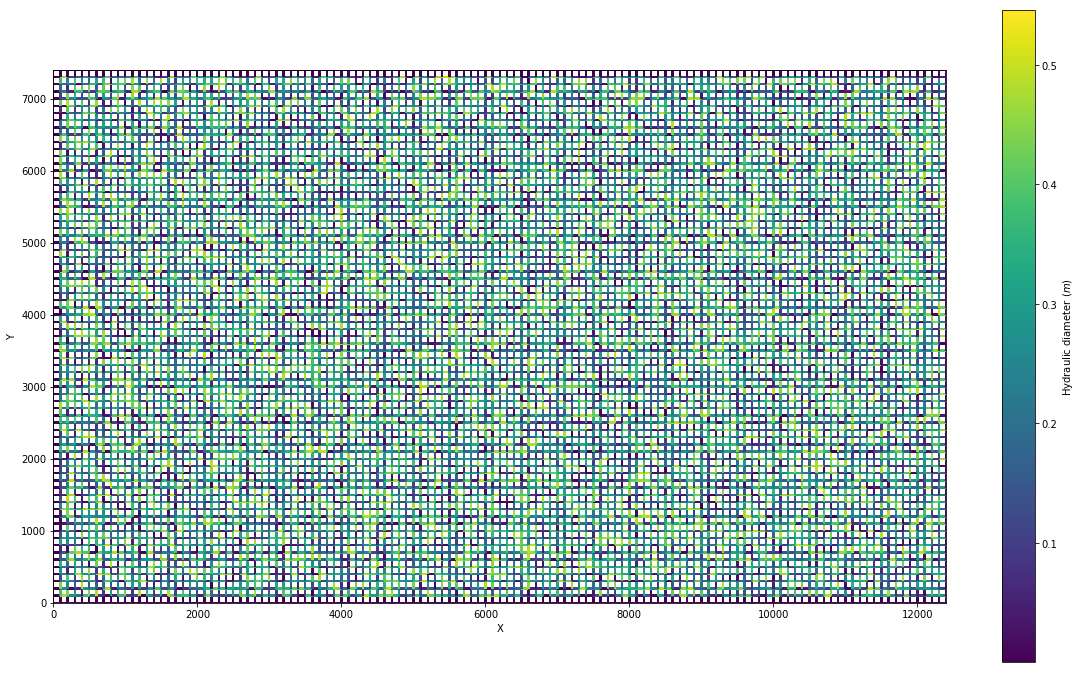

In [23]:
figure(figsize=(20,12))
plot_links(mg, 'hydraulic__diameter', var_name='Hydraulic diameter ($m$)', pixels_per_node=15, lw=5)

In [8]:
mc = MeltCreep(mg, dt=10000.)
